In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import time
import pickle

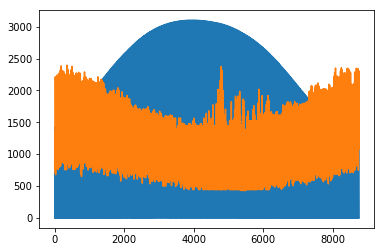

In [2]:
df = pd.read_csv('processed data.csv')
demand_total = df['Electricity:Facility [kW](Hourly)'].values*1000
solar_total = df['Normalized Solar Energy [kWh]'].values*1000
T = len(demand_total)
solar_extend = np.append(solar_total,np.zeros(T))
demand_extend = np.append(demand_total,np.zeros(T))
t = np.arange(0,T)
plt.plot(t,solar_total,label='solar')
plt.plot(t,demand_total,label='demand')

In [17]:
a = np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
b = np.append(a[-8:],a[:1])
c = a[::3]
c

array([1., 4., 7., 0., 0., 0.])

In [3]:
xi = .5
beta = 1 #????????
a = 2.0
b = 10.0
c = 27.0

In [4]:
def gradient_descent(variable,gradient,tol=1e-9,projection=lambda x: x,max_iter=1000,step_size=0.05,show=False):
    """
    Projected gradient descent.
    
    Inputs:
        variable: starting point
        grad: function mapping points to gradients
        function: compute function value at now variable
        tol: stopping threhold
        max_iter: maximum iteration
        step_size: learning rate
        projection(optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    iteration = 0
    diff_norm_variable = 9999.0
    while (diff_norm_variable > tol) & (iteration < max_iter):
        updated_variable = projection(variable + step_size*(-gradient(variable)))
        diff_norm_variable = np.linalg.norm(updated_variable - variable)
        variable = updated_variable
        iteration += 1
        if (iteration%100 == 0) & (show) :
            print('iteration: %d, difference between updates in norm: %.9f' % (iteration,diff_norm_variable))
    
    return variable

In [5]:
# Offline algorithm
def OFF(x0=0.0,show = False):
    print('offline algorithm started...')
    x_OFF = np.full(T,x0)
    gradient = lambda variable: quadratic_smoothed_gradient(variable,solar_total,demand_total)
    x_OFF = gradient_descent(variable=x_OFF,gradient=gradient,projection = projection,show=show)
    print('offline algorithm finished!')
    return x_OFF

In [6]:
x_OFF = OFF(show=True)

offline algorithm started...


NameError: name 'projection' is not defined

In [7]:
# Receding horizon control algorithm
def RHC(W,x0 = 0.0,show = False):
    print('Receding horizon control started...')
    x_RHC = np.full(T+1,x0)
    for i in range(1,T+1):
        x_temp = np.zeros(W) # Warning!
        gradient = lambda variable: quadratic_smoothed_gradient(variable,solar_extend[i-1:i+W-1],demand_extend[i-1:i+W-1],x0=x_RHC[i-1])
        x_temp = gradient_descent(variable=x_temp,gradient=gradient,projection = projection)
        x_RHC[i] = x_temp[0]
        if (i%1000 == 0) & (show):
            print('time step: %d, total steps: %d' % (i,T))
    x_RHC = np.delete(x_RHC,0)
    print('RHC finished!')
    return x_RHC

In [8]:
def quadratic_smoothed_gradient(variable,solar,demand,x0=0.0):
    variable_backward = np.append(x0,variable[:-1])
    variable_forward = np.append(variable[1:],0.0)
    gradient = 2*a*variable+b+2*xi*(variable+solar-demand)+beta*(2*variable-variable_backward-variable_forward)
    
    return gradient

In [9]:
def projection(variable):
    '''
    Define your projection
    '''
    return np.maximum(variable,0.0)

In [10]:
def RHGD(W, x0=0.0,gamma=1/(2*a),eta=1/(2*a+4*beta),show=False):
    print('Receding horizon gradient descent started...')
    '''
    Algorithm by Li et al. arXiv:1801.07780
    '''
    x_RHGD = np.full(T+1,x0)
    for s in range(2-W,T+1): # Careful here!
        # Initialize x_RHGD[s+W]
        if s+W <= T:
            online_gradient = lambda variable: online_quadratic_smoothed_gradient(0.0,variable,0.0,solar_total[s+W-2],demand_total[s+W-2])
            x_RHGD[s+W] = projection(x_RHGD[s+W-1]-gamma*online_gradient(x_RHGD[s+W-1]))
        # Update x_RHGD[s],...,x_RHGD[s+W-1] backwards
        for t in range(min(s+W-1,T),max(s,1)-1,-1): # Careful here!
            if t == T:
                x_RHGD[t] = projection(x_RHGD[t] - eta*online_quadratic_smoothed_gradient(x_RHGD[t-1],x_RHGD[t],0.0,solar_total[t-1],demand_total[t-1],beta = beta))
            else:
                x_RHGD[t] = projection(x_RHGD[t] - eta*online_quadratic_smoothed_gradient(x_RHGD[t-1],x_RHGD[t],x_RHGD[t+1],solar_total[t-1],demand_total[t-1],beta = beta))
        if (s%1000 == 0) & (show):
            print('time step: %d, total steps: %d' % (s,T))
    x_RHGD = np.delete(x_RHGD,0)
    print('RHGD finished!')
    return x_RHGD

In [11]:
def online_quadratic_smoothed_gradient(variable_backward,variable,variable_forward,solar,demand,beta = 0.0):
    gradient = 2*a*variable+b+2*xi*(variable+solar-demand)+beta*(2*variable-variable_backward-variable_forward)
    return gradient

In [12]:
def quadratic_smoothed_function(variable,solar,demand,x0=0.0):
    variable_backward = np.append(x0,variable[:-1])
    function = np.sum(a*variable**2+b*variable+c+xi*(variable+solar-demand)**2+0.5*beta*(variable-variable_backward)**2)
    
    return function

In [13]:
def plot_window_vs_regret(objective,offline_algorithm,*online_algorithms,x0 = 0.0,show = False):
    offline_variable = offline_algorithm()
    offline_function = objective(offline_variable)
    window = 6
    log_regrets = []
    for online_algorithm in online_algorithms:
        log_regret = []
        start = time.time()
        for w in range(1,window):
            if show:
                print('Look forward window = %d, total window = %d' % (w,window))
            online_variable = online_algorithm(w)
            online_function = objective(online_variable)
            log_regret.append(online_function / offline_function)
        elapsed = time.time()- start
        print('------Elapsed time is %f------' % (elapsed))
        t = np.arange(1,window)
        plt.plot(t,log_regret,label=online_algorithm.__name__)
        plt.legend()
        log_regrets.append(log_regret)
    plt.show()    
    return np.array(log_regrets)

offline algorithm started...
offline algorithm finished!
Look forward window = 1, total window = 6
Receding horizon gradient descent started...
RHGD finished!
Look forward window = 2, total window = 6
Receding horizon gradient descent started...
RHGD finished!
Look forward window = 3, total window = 6
Receding horizon gradient descent started...
RHGD finished!
Look forward window = 4, total window = 6
Receding horizon gradient descent started...
RHGD finished!
Look forward window = 5, total window = 6
Receding horizon gradient descent started...
RHGD finished!
------Elapsed time is 0.800561------
Look forward window = 1, total window = 6
Receding horizon control started...
RHC finished!
Look forward window = 2, total window = 6
Receding horizon control started...
RHC finished!
Look forward window = 3, total window = 6
Receding horizon control started...
RHC finished!
Look forward window = 4, total window = 6
Receding horizon control started...
RHC finished!
Look forward window = 5, tot

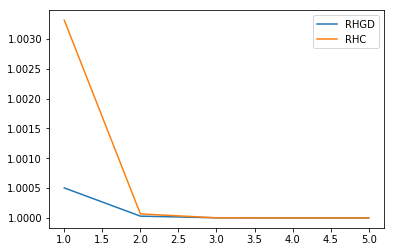

In [15]:
function = lambda variable: quadratic_smoothed_function(variable,solar_total,demand_total)
log_regrets = plot_window_vs_regret(function,OFF,RHGD,RHC,show=True)